In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from functools import partial
import sys
sys.path.insert(0, '..')
import harmonic as hm
sys.path.append("../examples")
import utils
# from matplotlib import cm

In [2]:
def ln_prior_uniform(x, xmin=-6.0, xmax=6.0, ymin=-6.0, ymax=6.0):
    if x[0] >= xmin and x[0] <= xmax and x[1] >= ymin and x[1] <= ymax:        
        return 1.0 / ( (xmax - xmin) * (ymax - ymin) )
    else:
        return 0.0

In [3]:
def ln_likelihood(x):
    f = (x[0]**2 + x[1] - 11.0)**2 + (x[0] + x[1]**2 - 7.0)**2
    return -f

In [4]:
def ln_posterior(x, ln_prior):
    ln_L = ln_likelihood(x)

    if not np.isfinite(ln_L):
        return -np.inf
    else:
        return ln_prior(x) + ln_L

In [5]:
# Define parameters for emcee sampling
ndim = 2                    # number of dimensions
nchains = 200               # total number of chains to compute
samples_per_chain = 5000    # number of samples per chain
nburn = 2000                # number of samples to discard as burn in

# Initialize random seed
np.random.seed(4)

# Define ln_prior function
xmin = -6.0
xmax = 6.0
ymin = -6.0
ymax = 6.0  
ln_prior = partial(ln_prior_uniform, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)  

In [6]:
# Set initial random position and state
pos = np.random.rand(ndim * nchains).reshape((nchains, ndim)) * 10 - 5
rstate = np.random.get_state()

# Instantiate and execute sampler 
sampler = emcee.EnsembleSampler(nchains, ndim, ln_posterior, args=[ln_prior])
(pos, prob, state) = sampler.run_mcmc(pos, samples_per_chain, rstate0=rstate) 

# Collect samples into contiguous numpy arrays (discarding burn in)
samples = np.ascontiguousarray(sampler.chain[:,nburn:,:])
lnprob = np.ascontiguousarray(sampler.lnprobability[:,nburn:])

In [7]:
samples_flat=samples.reshape((-1,ndim))
lnprob_flat=lnprob.reshape((-1,1))

(-4.0, -3.0) nsample_means: 37 npos: 35
(-3.0, 3.0) nsample_means: 50 npos: 50
(4.0, -2.0) nsample_means: 52 npos: 44
(3.0, 2.0) nsample_means: 61 npos: 60


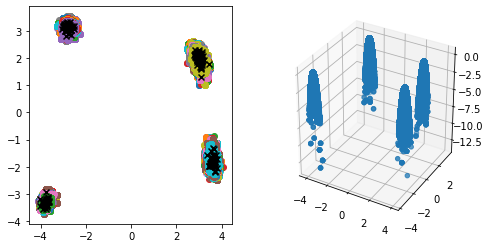

In [8]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax1 = fig.add_subplot(1, 2, 1)
means=np.zeros([2,nchains])
for ichain in range(nchains):
    ax1.scatter(samples[ichain,:,0],samples[ichain,:,1])
    (means[0,ichain],means[1,ichain])=(np.round(np.mean(samples[ichain,...],axis=0)))
ax1.scatter(pos[:,0],pos[:,1],marker='x',color='k');

peaks=[(-4.,-3.), (-3.,3.), (4.,-2.), (3.,2.)]
for ipeak in range(len(peaks)):
    (i,j)=(0,0)
    for imean in range(nchains):
        if means[0,imean]==peaks[ipeak][0] and means[1,imean]==peaks[ipeak][1]:
            i=i+1
        if np.round(pos[imean,0])==peaks[ipeak][0] and np.round(pos[imean,1])==peaks[ipeak][1]:
            j=j+1
    print(peaks[ipeak], 'nsample_means:', i, 'npos:', j)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.scatter(samples_flat[:,0],samples_flat[:,1],lnprob_flat);

In [9]:
chains = hm.Chains(ndim)
chains.add_chains_3d(samples, lnprob)
chains_train, chains_test = hm.utils.split_data(chains, 
                                                training_proportion=0.5)

In [10]:
ln_posterior_func = partial(ln_posterior, ln_prior=ln_prior)
ln_posterior_grid, x_grid, y_grid = \
        utils.eval_func_on_grid(ln_posterior_func, 
                                    xmin=-6.0, xmax=6.0, 
                                    ymin=-6.0, ymax=6.0, 
                                    nx=1000, ny=1000)
dx = x_grid[0,1] - x_grid[0,0]
dy = y_grid[1,0] - y_grid[0,0]
evidence_numerical_integration = \
                         np.sum(np.exp(ln_posterior_grid)) * dx * dy

# Models

## KDE (Jason thinks this will be a poor fit)

In [11]:
domain = [] # not used for KDE model
kde_diameter = 0.01 # we are selecting this as cross-val finds it to be optimal
model = hm.model.KernelDensityEstimate(ndim, domain, hyper_parameters=[kde_diameter])
fit_success = model.fit(chains_train.samples, chains_train.ln_posterior)

In [12]:
model_grid, x_grid, y_grid = \
    utils.eval_func_on_grid(model.predict, 
                            xmin=xmin, xmax=xmax, 
                            ymin=ymin, ymax=ymax, 
                            nx=1000, ny=1000)

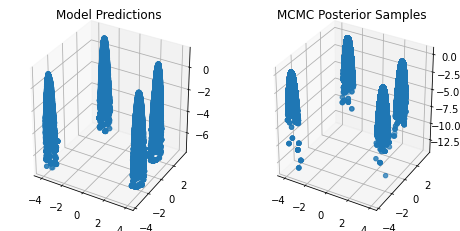

In [13]:
fig=plt.figure(figsize=plt.figaspect(0.5))
ax1=fig.add_subplot(1,2,1,projection='3d')
ax1.scatter(x_grid, y_grid, model_grid)
ax1.set_title('Model Predictions')
ax2=fig.add_subplot(1,2,2,projection='3d')
ax2.scatter(samples_flat[:,0],samples_flat[:,1],lnprob_flat)
ax2.set_title('MCMC Posterior Samples');
# ax2.set_zlim(-6,0);

In [14]:
# Instantiate harmonic's evidence class
ev = hm.Evidence(chains_test.nchains, model)

# Pass the evidence class the inference chains and compute the evidence!
ev.add_chains(chains_test)
evidence, evidence_std = ev.compute_evidence()

In [15]:
print('Evidence (Harmonic): {} ± {}'.format(evidence, evidence_std))
print('Evidence (Numerical): {}'.format(evidence_numerical_integration))
print('nsigma = {}'.format(np.abs(evidence - evidence_numerical_integration) / evidence_std))

Evidence (Harmonic): 0.4066723123928195 ± 0.006162070538207138
Evidence (Numerical): 0.409943977925179
nsigma = 0.5309360728790715
